In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
landmarks_frame = pd.read_csv('../faces/face_landmarks.csv')

In [4]:
len(landmarks_frame)

69

In [5]:
n = 65

img_name = landmarks_frame.iloc[n,0]                     #找到第65 + 2个图片
landmarks = landmarks_frame.iloc[n,1:].as_matrix()       #取得该图片的所有landmarks
landmarks = landmarks.astype('float').reshape(-1,2)      #将landmarks 分为两列。-1表示不确定有多少行，但是确定要分为两列

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))     # 取出前4行

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


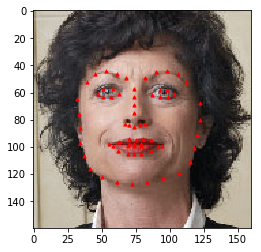

In [6]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='^', c='r') ### 取第0列的所有点作为x，取第1列的所有点作为y
    
    #plt.plt.scatter(landmarks[0, 0], landmarks[0, 1], s=10, marker='_', c='r')  ## 解开注释则只标记一个点
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('../faces/', img_name)),
               landmarks)
plt.show()

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

+ __len____ so that len(dataset) returns the size of the dataset.
+ __getitem__ to support the indexing such that dataset[i] can be used to get i

Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}

In [7]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(landmarks_frame)
    def __getitem__(self, idx):
        img_name = self.landmarks_frame.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, img_name)
        image = io.imread(img_name)                          ###使用skimage.io.imread读取图片，将图片以ndarry表示
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()    ### 将dataframe转成matrix，找到第idx行，第一列之后的所有
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


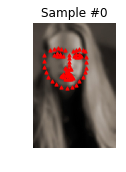

1 (500, 333, 3) (68, 2)


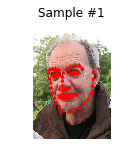

2 (250, 258, 3) (68, 2)


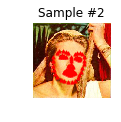

3 (434, 290, 3) (68, 2)


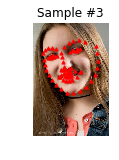

In [8]:
face_dataset = FaceLandmarksDataset('../faces/face_landmarks.csv', '../faces')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i,sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample['image'],sample['landmarks'])
    if i == 3:
        plt.show()
        break


+    Rescale: to scale the image    __按比例缩进__
+    RandomCrop: to crop from image randomly. This is data augmentation.
+    ToTensor: to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement **\__call__** method and if required, **\__init__** method. We can then use a transform like this:

tsfm = Transform(params)

transformed_sample = tsfm(sample)

About \__call__, see this link: https://blog.csdn.net/Yaokai_AssultMaster/article/details/70256621

**\__init__**  function to construct a instance, **\__call__** function make this instance callable


In [9]:
class Rescale(object):
    
    """
       Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size,(int, tuple))  
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        landmarks = landmarks * [new_w/w, new_h/h]  ## h is height, w is width, so x * w, y * h
        
        return {'image': img, 'landmarks': landmarks}            

Before image shape is (500, 333, 3)
After Rescaled, image shape is (384, 256, 3)


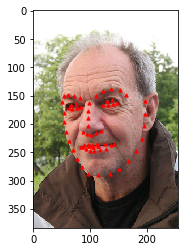

In [10]:
scale = Rescale(256)   ### input is int
sample = face_dataset[1]
rescaled_sample = scale(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(rescaled_sample['image'].shape))
show_landmarks(rescaled_sample['image'],rescaled_sample['landmarks'])

Before image shape is (500, 333, 3)
After Rescaled, image shape is (256, 256, 3)


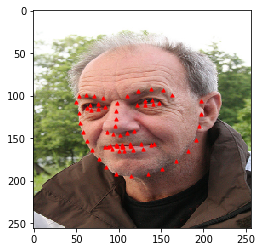

In [11]:
scale = Rescale((256,256))   ### input is tuple
sample = face_dataset[1]
rescaled_sample = scale(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(rescaled_sample['image'].shape))
show_landmarks(rescaled_sample['image'],rescaled_sample['landmarks'])

In [12]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top: top + new_h, 
                     left: left + new_w]
        
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}        

Before image shape is (500, 333, 3)
After Rescaled, image shape is (224, 224, 3)


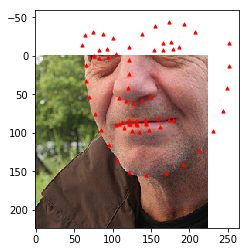

In [13]:
crop = RandomCrop(224)   ### input is int
sample = face_dataset[1]
croped_sample = crop(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(croped_sample['image'].shape))
show_landmarks(croped_sample['image'],croped_sample['landmarks'])

直接crop 会导致样本丢失， 如果先rescale, 再crop 则会好些

Before image shape is (500, 333, 3)
After Rescaled, image shape is (384, 256, 3)


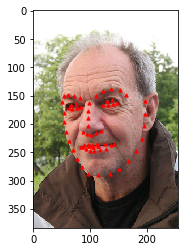

Before image shape is (384, 256, 3)
After crop, image shape is (224, 224, 3)


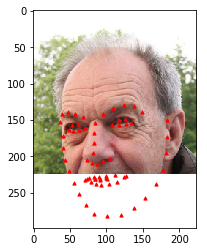

In [14]:
scale = Rescale((256))   ### input is tuple
sample = face_dataset[1]
rescaled_sample = scale(sample)
print("Before image shape is {}".format(sample['image'].shape))
print("After Rescaled, image shape is {}".format(rescaled_sample['image'].shape))
show_landmarks(rescaled_sample['image'],rescaled_sample['landmarks'])


crop = RandomCrop(224)   ### input is int
croped_sample = crop(rescaled_sample)
print("Before image shape is {}".format(rescaled_sample['image'].shape))
print("After crop, image shape is {}".format(croped_sample['image'].shape))
show_landmarks(croped_sample['image'],croped_sample['landmarks'])

In [15]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### 第一张图单独进行rescale(256)
### 第二张图在原图基础上单独进行 crop(128)
### 第三张图先rescale(256), 再进行crop(224)

The original shape is (500, 333, 3)
after Rescale, the shape is (384, 256, 3)


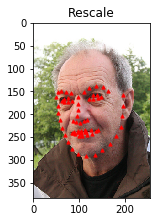

after RandomCrop, the shape is (128, 128, 3)


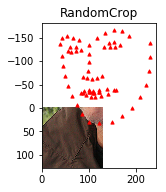

after Compose, the shape is (224, 224, 3)


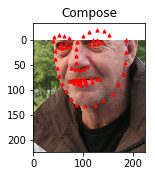

In [16]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224),
                              ])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[1]
print("The original shape is {}".format(sample['image'].shape))
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print("after {}, the shape is {}".format(type(tsfrm).__name__, transformed_sample['image'].shape))
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

   + An image is read from the file on the fly
   + Transforms are applied on the read image
   + Since one of the transforms is random, data is augmentated on sampling


In [17]:
transformed_dataset = FaceLandmarksDataset(csv_file='../faces/face_landmarks.csv',
                                           root_dir='../faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


__torch.utils.data.DataLoader__ is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2]) torch.FloatTensor


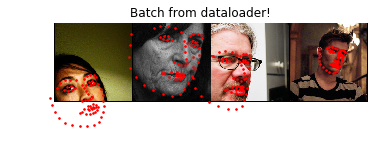

In [113]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader!')

for i_batch, sample_batched in enumerate(dataloader):    ### dataloader 每次出来一个batch, 每个batch
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size(),
         sample_batched['image'].float().type(),
         )

    # observe 6th batch and stop.  只显示第六个batch的四张图
    if i_batch == 5:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


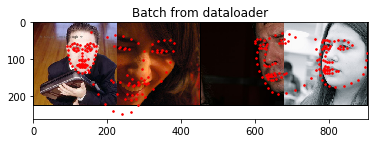

In [114]:
for idx, sample_batched in enumerate(dataloader):
    if idx==1 :
        
        images_batch, landmarks_batch = \
                sample_batched['image'], sample_batched['landmarks']
        batch_size = len(images_batch)
        im_size = images_batch.size(2)

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        for i in range(batch_size):
            plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                        landmarks_batch[i, :, 1].numpy(),
                        s=10, marker='.', c='r')

            plt.title('Batch from dataloader')

In [115]:
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train_model(model, criterion, optimizer, scheduler, num_epoch = 1):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000
    
    for epoch in range(num_epoch):
        
        print('Epoch {}/{}'.format(epoch, num_epoch-1))
        print("-" * 20)
        
        model.train()
        
        running_loss = 0.0
        
        for sample_batched in dataloader:
            images_batch = sample_batched['image']
            landmarks_batch = sample_batched['landmarks']
            #print("landmarks_batch size is {}".format(landmarks_batch.size()))
            images_batch = images_batch.to(device)
            landmarks_batch = landmarks_batch.to(device)
            
            optimizer.zero_grad()
        
            with torch.set_grad_enabled(True):
                #print("input size to model is {}".format(images_batch.size()))
                outputs = model(images_batch.float())
                outputs = outputs.view(outputs.size(0),68,-1)


                #print("output size is {}, type is {}".format(outputs.size(), outputs.type()))
                #print("landmarks_batch size is {}, type is {}".format(landmarks_batch.size(), landmarks_batch.type()))
                
                different = outputs - landmarks_batch.float()
                
                #print("outputs - landmarks_batch is {}, type is {}".format(different, different.type()))
                #print("current epoch is {}".format(epoch))
                loss = torch.norm(different)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images_batch.size(0)
        
        epoch_loss = running_loss / 69
        print('Loss: {:.4f}'.format(epoch_loss))
        
        if epoch_loss < best_loss:
            print("save best ")
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed //60, time_elapsed %60))
    
    model.load_state_dict(best_model_wts)
    return model

In [122]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 68*2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.009, momentum= 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [142]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epoch=500)

Epoch 0/499
--------------------
Loss: 270.5711
save best 
Epoch 1/499
--------------------
Loss: 222.0488
save best 
Epoch 2/499
--------------------
Loss: 218.5961
save best 
Epoch 3/499
--------------------
Loss: 212.2600
save best 
Epoch 4/499
--------------------
Loss: 228.0096
Epoch 5/499
--------------------
Loss: 239.7815
Epoch 6/499
--------------------
Loss: 234.3071
Epoch 7/499
--------------------
Loss: 244.9117
Epoch 8/499
--------------------
Loss: 258.2956
Epoch 9/499
--------------------
Loss: 246.1257
Epoch 10/499
--------------------
Loss: 230.9861
Epoch 11/499
--------------------
Loss: 277.7423
Epoch 12/499
--------------------
Loss: 265.2973
Epoch 13/499
--------------------
Loss: 234.8535
Epoch 14/499
--------------------
Loss: 221.4956
Epoch 15/499
--------------------
Loss: 258.6169
Epoch 16/499
--------------------
Loss: 280.1870
Epoch 17/499
--------------------
Loss: 254.2480
Epoch 18/499
--------------------
Loss: 261.8250
Epoch 19/499
--------------------
L

Loss: 187.1185
Epoch 164/499
--------------------
Loss: 196.1485
Epoch 165/499
--------------------
Loss: 162.8738
Epoch 166/499
--------------------
Loss: 184.1600
Epoch 167/499
--------------------
Loss: 182.6919
Epoch 168/499
--------------------
Loss: 174.0733
Epoch 169/499
--------------------
Loss: 168.7237
Epoch 170/499
--------------------
Loss: 196.5365
Epoch 171/499
--------------------
Loss: 184.3188
Epoch 172/499
--------------------
Loss: 167.0601
Epoch 173/499
--------------------
Loss: 148.9246
save best 
Epoch 174/499
--------------------
Loss: 197.5656
Epoch 175/499
--------------------
Loss: 190.1449
Epoch 176/499
--------------------
Loss: 170.3590
Epoch 177/499
--------------------
Loss: 158.7075
Epoch 178/499
--------------------
Loss: 168.4985
Epoch 179/499
--------------------
Loss: 177.0350
Epoch 180/499
--------------------
Loss: 164.4166
Epoch 181/499
--------------------
Loss: 193.6800
Epoch 182/499
--------------------
Loss: 200.6638
Epoch 183/499
----------

Loss: 147.2013
Epoch 327/499
--------------------
Loss: 150.5260
Epoch 328/499
--------------------
Loss: 176.7185
Epoch 329/499
--------------------
Loss: 163.7400
Epoch 330/499
--------------------
Loss: 165.7859
Epoch 331/499
--------------------
Loss: 161.8973
Epoch 332/499
--------------------
Loss: 140.3845
Epoch 333/499
--------------------
Loss: 142.2758
Epoch 334/499
--------------------
Loss: 169.0914
Epoch 335/499
--------------------
Loss: 146.1977
Epoch 336/499
--------------------
Loss: 148.3971
Epoch 337/499
--------------------
Loss: 152.4705
Epoch 338/499
--------------------
Loss: 170.7988
Epoch 339/499
--------------------
Loss: 130.1561
Epoch 340/499
--------------------
Loss: 159.2291
Epoch 341/499
--------------------
Loss: 162.8950
Epoch 342/499
--------------------
Loss: 165.1843
Epoch 343/499
--------------------
Loss: 181.9677
Epoch 344/499
--------------------
Loss: 136.0994
Epoch 345/499
--------------------
Loss: 153.3371
Epoch 346/499
--------------------


Loss: 122.1663
Epoch 490/499
--------------------
Loss: 114.3028
Epoch 491/499
--------------------
Loss: 116.1039
Epoch 492/499
--------------------
Loss: 124.7352
Epoch 493/499
--------------------
Loss: 139.7136
Epoch 494/499
--------------------
Loss: 112.6939
Epoch 495/499
--------------------
Loss: 108.1991
Epoch 496/499
--------------------
Loss: 117.7914
Epoch 497/499
--------------------
Loss: 128.5182
Epoch 498/499
--------------------
Loss: 110.8772
Epoch 499/499
--------------------
Loss: 136.3899
Training complete in 5m 53s


In [143]:
def visualize_model(model, num_image = 6):

    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for idx, sample_batched in enumerate(dataloader):
            if idx==1 :
                images_batch = sample_batched['image']
                print(images_batch.size())
                images_batch = images_batch.to(device)
            
                landmarks_batch = model(images_batch.float())
                landmarks_batch = landmarks_batch.view(landmarks_batch.size(0),68,-1)
                landmarks_batch = landmarks_batch.cpu()
            

                batch_size = len(images_batch)
                im_size = images_batch.size(2)

                grid = utils.make_grid(images_batch.cpu())
                plt.imshow(grid.numpy().transpose((1, 2, 0)))

                for i in range(batch_size):
                    plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                                landmarks_batch[i, :, 1].numpy(),
                                s=10, marker='.', c='r')

                    plt.title('Test train set')

torch.Size([4, 3, 224, 224])


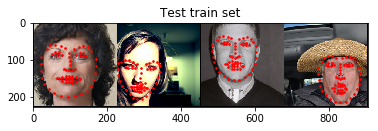

In [144]:
visualize_model(model_ft)

In [145]:
import cv2
#my_pict_url = 'test_face/lan.jpg'

def test_face_detection(url):
    img = io.imread(url)

    resized_image = cv2.resize(img, (224, 224)) 
    #print(resized_image.shape)
    resized_image = resized_image.transpose(0,1,2)

    transform1 = transforms.Compose([  
        transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]  
        ]  
    )  


    with torch.no_grad():

        new_img = transform1(resized_image)
        new_img = new_img.view(1,3,224,224)
        new_img = new_img.to(device)
        #print(new_img.size())
        landmarks_batch = model_ft(new_img)
        landmarks_batch = landmarks_batch.view(landmarks_batch.size(0),68,-1)
        landmarks_batch = landmarks_batch.cpu()

        landmarks_batch.numpy()

        batch_size = len(new_img)
        im_size = images_batch.size(2)
        
        plt.figure()
        plt.imshow(resized_image)
        

        for i in range(batch_size):
            plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                        landmarks_batch[i, :, 1].numpy(),
                        s=10, marker='^', c='r')

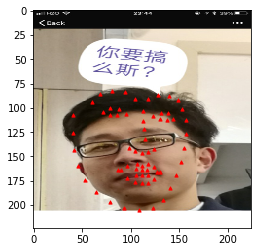

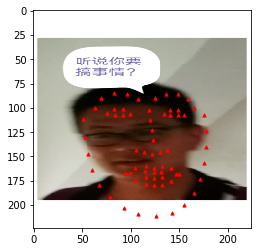

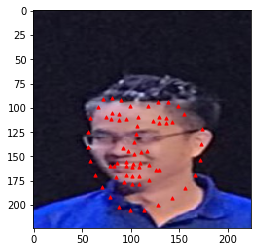

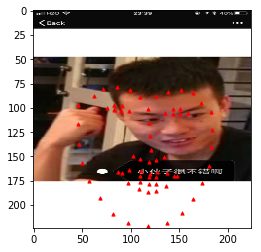

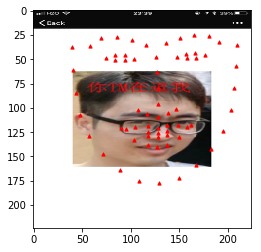

In [147]:
urls = ["lan.jpg","zhe.jpg","shu.jpeg","tan.jpg","yun.jpg"]
for url in urls:
    url = os.path.join("test_face",url)
    test_face_detection(url)